# Feature Engineering

This notebook is used to explore the feature set and create an optimal set.  I previously had a misunderstanding of the difference between categorical and quantitive variables so I intend to remedy this in this notebook and explain why.

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../scripts/'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import features

In [2]:
train_raw = pd.read_csv('../data/train.csv', header=0)
test_raw = pd.read_csv('../data/test.csv', header=0)
data_raw = pd.concat([train_raw, test_raw])

# Original Features

This is the feature set originally used in the second attempt.  I am recording it here so that I have a record of the transformations I did any why I made those choices. I have included a Pearson correlation heatmap to show that I originally included heavily correlated features.

In [3]:
data_raw['Fam_size'] = data_raw['SibSp'] + data_raw['Parch'] + 1

titles = ['Mr.', 'Miss.', 'Mrs.', 'Master.']
data_raw['Surname'] = data_raw['Name'].str.extract('(,\s)(.*\.)', expand=False)[1]
data_raw.loc[~data_raw['Surname'].isin(titles),'Surname'] = 'Rare'
categorical_features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Fam_size', 'Surname']
numerical_features = ['Age', 'Fare']
target = 'Survived'
data_clean = features.decision_tree_preprocessing(data_raw, 
                                                  target,
                                                  categorical_features=categorical_features, 
                                                  numerical_features=numerical_features, 
                                                  drop_na_columns=['Embarked'])
data_clean['AgeXFare'] = data_clean['Age'] * data_clean['Fare']

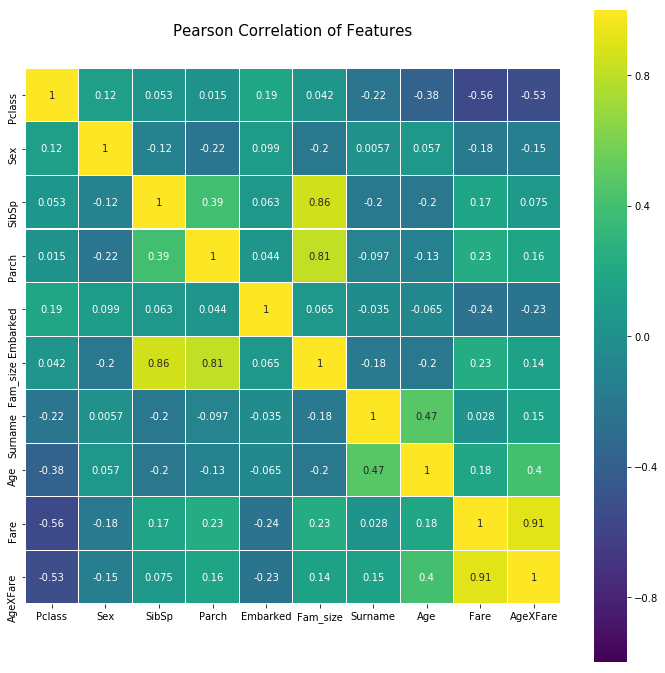

In [4]:
cmp = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(data_clean.drop(target, axis=1).astype(float).corr(),linewidths=0.1,vmax=1.0, vmin=-1.0, square=True, cmap=cmp, 
            linecolor='white', annot=True)

# Creating a better feature set

First examine the training set to compare survival rates and the data.

In [5]:
df = data_raw.dropna(subset=['Survived'])

# Family Size

Family size is a discrete quantitative variable. As such, this will not require 1-hot encoding.

First I will plot the survival rates at each discrete value in Parch, SibSp, and Fam size to see if there is a significant discrepancy.  Included is a plot of survival counts to show how heavy of a class imbalance there is in survival rates.

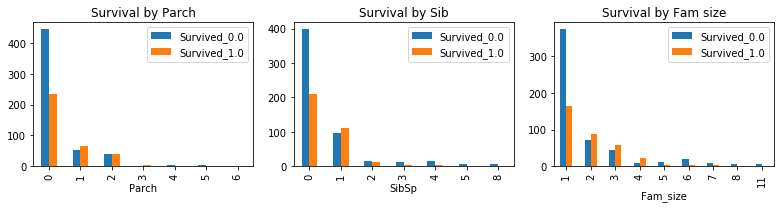

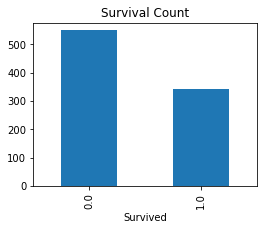

In [6]:
fig, axs = plt.subplots(ncols=3, figsize=(11, 3))

# Parch
df_parch = pd.get_dummies(df[['Parch', target]], columns=[target])
df_parch = df_parch.groupby('Parch').agg('sum').astype(int)
df_parch.plot.bar(ax=axs[0])
axs[0].set_title('Survival by Parch')

# SibSp
df_sib = pd.get_dummies(df[['SibSp', target]], columns=[target])
df_sib = df_sib.groupby('SibSp').agg('sum').astype(int)
df_sib.plot.bar(ax=axs[1])
axs[1].set_title('Survival by Sib')

# Fam size
df_fam = pd.get_dummies(df[['Fam_size', target]], columns=[target])
df_fam = df_fam.groupby('Fam_size').agg('sum').astype(int)
df_fam.plot.bar(ax=axs[2])
axs[2].set_title('Survival by Fam size')

fig.tight_layout()

# Survival count
fig = plt.figure(figsize=(4,3))

df['Survived'].value_counts().plot.bar(title='Survival Count')
plt.xlabel('Survived')

Looking at the Fam size graph, individuals with no family died at much higher rate than those with family members aboard. Since Parch and SibSp are heavily correlated with Fam size, I will remove them from the feature set. 

Next we will look at the effect of the survival rate among individuals who are alone against the survival rate of individuals with family members aboard and the survival rate among different sizes of families.

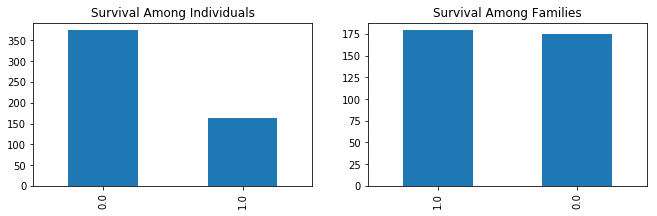

In [15]:
fig, axs = plt.subplots(ncols=2, figsize=(11, 3))

# Individuals
df_ind = df.loc[df['Fam_size'] == 1, 'Survived'].value_counts()
df_ind.plot.bar(ax=axs[0])
axs[0].set_title('Survival Among Individuals')

# With family
df_fam = df.loc[df['Fam_size'] > 1, 'Survived'].value_counts()
df_fam.plot.bar(ax=axs[1])
axs[1].set_title('Survival Among Families')

# Combine 4+ for fam

Looks as if survival rate drops among individuals with a large amount of family aboard the ship but there may not be enough data to show this.